In [1]:
%load_ext autoreload
%autoreload 2
%cd ..

/home/akkirr/annotated-diffusion


In [16]:
%matplotlib inline
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from pathlib import Path

import torch
from torch import nan_to_num
from torchvision import transforms
from torch.utils.data import DataLoader

import numpy as np
from PIL import Image
import requests

from datasets import load_dataset
from torchvision.utils import save_image
from torch.optim import Adam

In [3]:
from mylib import *

In [4]:
sampler = Sampler(linear_beta_schedule, 300)

In [9]:
# load dataset from the hub
dataset = load_dataset("fashion_mnist")
image_size = 28
channels = 1
batch_size = 128

Found cached dataset fashion_mnist (/home/akkirr/.cache/huggingface/datasets/fashion_mnist/fashion_mnist/1.0.0/0a671f063342996f19779d38c0ab4abef9c64f757b35af8134b331c294d7ba48)


  0%|          | 0/2 [00:00<?, ?it/s]

In [17]:
# define image transformations (e.g. using torchvision)
transform = Compose([
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Lambda(lambda t: (t * 2) - 1)
])

# define function
def transforms(examples):
   examples["pixel_values"] = [transform(image.convert("L")) for image in examples["image"]]
   del examples["image"]

   return examples

transformed_dataset = dataset.with_transform(transforms).filter(lambda x: x['label'] != 0).remove_columns("label")

# create dataloader
dataloader = DataLoader(transformed_dataset["train"], batch_size=batch_size, shuffle=True)

Filter:   0%|          | 0/60000 [00:00<?, ? examples/s]

Filter:   0%|          | 0/10000 [00:00<?, ? examples/s]

In [18]:
batch = next(iter(dataloader))
print(batch.keys())

dict_keys(['pixel_values'])


In [29]:
results_folder = Path("./results")
results_folder.mkdir(exist_ok = True)
save_and_sample_every = 100

In [24]:
device = "cuda" if torch.cuda.is_available() else "cpu"

model = Unet(
    dim=image_size,
    channels=channels,
    dim_mults=(1, 2, 4,)
)
model.to(device)

optimizer = Adam(model.parameters(), lr=1e-3)

In [25]:
epochs = 6

for epoch in range(epochs):
    for step, batch in enumerate(dataloader):
      optimizer.zero_grad()

      batch_size = batch["pixel_values"].shape[0]
      batch = batch["pixel_values"].to(device)

      # Algorithm 1 line 3: sample t uniformally for every example in the batch
      t = torch.randint(0, sampler.timesteps, (batch_size,), device=device).long()

      loss = sampler.p_losses(model, batch, t, loss_type="huber")

      if step % 100 == 0:
        print("Loss:", loss.item())

      loss.backward()
      optimizer.step()

      # save generated images
      if step != 0 and step % save_and_sample_every == 0:
        milestone = step // save_and_sample_every
        batches = num_to_groups(4, batch_size)
        all_images_list = list(map(lambda n: sampler.sample(model, batch_size=n, channels=channels), batches))
        all_images = torch.cat(all_images_list, dim=0)
        all_images = (all_images + 1) * 0.5
        save_image(all_images, str(results_folder / f'sample-{milestone}.png'), nrow = 6)

Loss: 0.431885689496994
Loss: 0.06605594605207443
Loss: 0.06149551272392273
Loss: 0.03977305069565773
Loss: 0.04752872511744499
Loss: 0.043250881135463715
Loss: 0.03332145884633064
Loss: 0.042194802314043045
Loss: 0.03904230520129204
Loss: 0.03531350940465927
Loss: 0.044924892485141754
Loss: 0.0407998152077198
Loss: 0.03502178564667702
Loss: 0.037598077207803726
Loss: 0.03176675736904144
Loss: 0.033711377531290054
Loss: 0.03886811435222626
Loss: 0.033614158630371094
Loss: 0.033599309623241425
Loss: 0.0305852722376585
Loss: 0.034657806158065796
Loss: 0.0335674025118351
Loss: 0.040845632553100586
Loss: 0.03615209832787514
Loss: 0.03497881069779396
Loss: 0.027427595108747482
Loss: 0.030544420704245567
Loss: 0.03109610266983509
Loss: 0.03225363790988922
Loss: 0.039461761713027954


In [ ]:
# sample 64 images
samples = sampler.sample(model, image_size=image_size, batch_size=64, channels=channels)

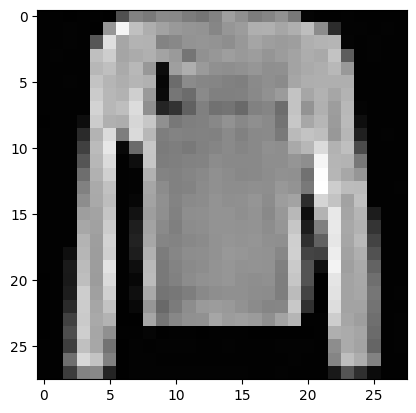

In [49]:
# show a random one
random_index = np.random.randint(0, 64)
plt.imshow(samples[-1][random_index].reshape(image_size, image_size, channels), cmap="gray")

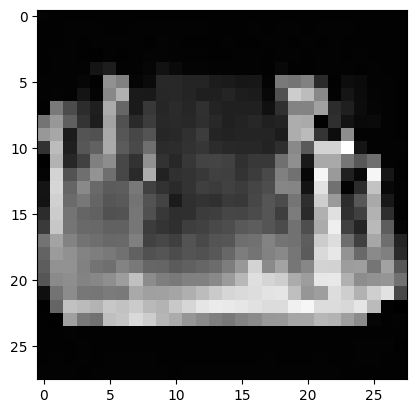

In [50]:
import matplotlib.animation as animation

random_index = 0

fig = plt.figure()
ims = []
for i in range(sampler.timesteps):
    im = plt.imshow(samples[i][random_index].reshape(image_size, image_size, channels), cmap="gray", animated=True)
    ims.append([im])

animate = animation.ArtistAnimation(fig, ims, interval=50, blit=True, repeat_delay=1000)
animate.save('diffusion.gif')
plt.show()